In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from models.lstm_ad import LSTM_AD

from utils.data import load_df, load_df_with_names, load_df_by_names
from utils.metrics import f1_score, far, mar

from typing import Dict



In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
# redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Pressure','Temperature', 'Thermocouple' ]
redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Thermocouple' ]

In [4]:
df_train = pd.read_csv("./data/valve1/6.csv", sep=";", parse_dates=True, index_col="datetime")
df_train.sort_index(inplace=True)

first_anomaly_idx = df_train.index.get_loc(df_train[df_train["anomaly"] == 1].index[0])
df_train = df_train.drop(redundant_features, axis=1)
train_size = int(first_anomaly_idx * 0.9)
train_size

518

In [5]:
x_train = df_train[:train_size]
x_train.head(3)

,Pressure,Temperature,Volume Flow RateRMS
datetime,,,
2020-03-09 12:14:36,0.382638,71.2129,32.0000
2020-03-09 12:14:37,0.710565,71.4284,32.0104
2020-03-09 12:14:38,0.054711,71.3468,32.0000


In [6]:
from utils.pipeline import Pipeline, Predictor
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
class Config:
    TIME_STEPS = 50
    epochs = 5
    batch_size = 10 
    Q = 0.99
    
conf = Config

class LSTM_AD_2ndPredictor:
    def fit(self, df_train):
        ss = StandardScaler()
        self.ss = ss
        x_train = df_train[:train_size]
        x_train = np.array(ss.fit_transform(x_train))
        x_train = create_sequences(x_train, conf.TIME_STEPS)

        self.model = LSTM_AD(optimizer=optimizer)
        self.model.fit(x_train, epochs=conf.epochs, batch_size=conf.batch_size)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df.drop(redundant_features, axis=1)
            x_test = np.array(self.ss.transform(df))
            x_test = create_sequences(x_test, conf.TIME_STEPS)
            r = pd.Series(np.sum(np.mean(np.abs(self.model.predict(x_test) - x_test), axis=1), axis=1)) 
            
            smoothed = r.rolling(window = 10).mean().fillna(r.iloc[0])
            a = smoothed#.diff(10).abs()
            
            IQR = a.quantile(0.75) - a.quantile(0.75)
            UCL = a.quantile(0.75) + 1.5 * IQR
            
            plt.plot(a)
            plt.axhline(UCL, color='r')
            plt.show()
            
            s = a > UCL
            w = 10
            is_anomaly = s.rolling(window = w).mean().fillna(s.iloc[0])
            anomalous_data_indices = pd.Series(is_anomaly.index[is_anomaly > 0]) #+ conf.TIME_STEPS - 1

            prediction = pd.Series(data=0, index=df.index)
            prediction.iloc[anomalous_data_indices] = 1
            predictions[file_name] = prediction
            
        return predictions
    

In [7]:
%%time
predictor = LSTM_AD_2ndPredictor()
predictor.fit(df_train)


Epoch 1/5
47/47 [==============================] - 9s 103ms/step - loss: 0.9161
Epoch 2/5
47/47 [==============================] - 5s 114ms/step - loss: 0.8131
Epoch 3/5
47/47 [==============================] - 4s 95ms/step - loss: 0.7852
Epoch 4/5
47/47 [==============================] - 4s 88ms/step - loss: 0.7620
Epoch 5/5
47/47 [==============================] - 5s 107ms/step - loss: 0.7384
CPU times: total: 1min 5s
Wall time: 29.5 s


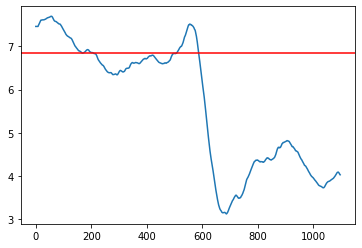

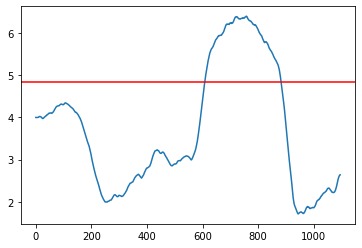

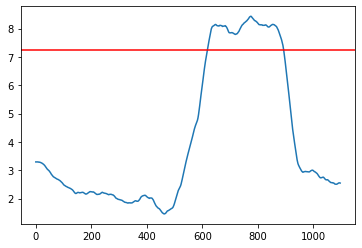

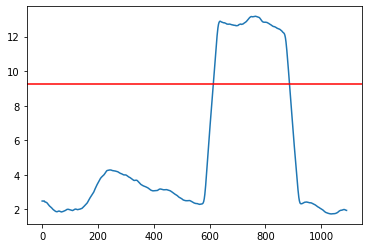

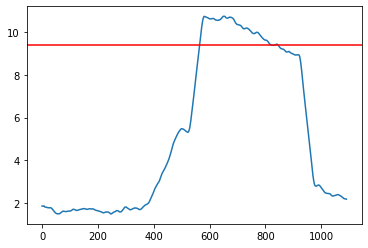

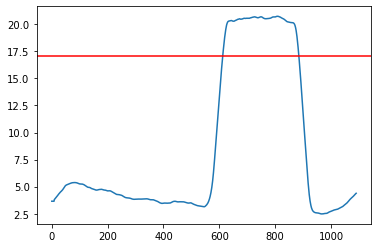

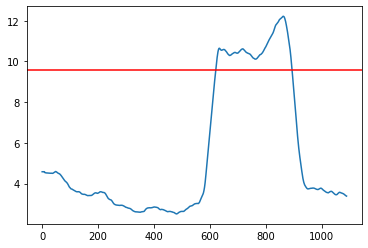

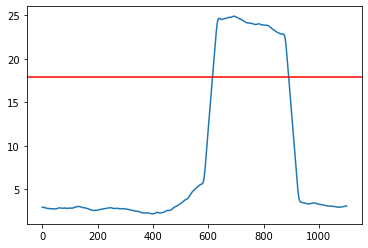

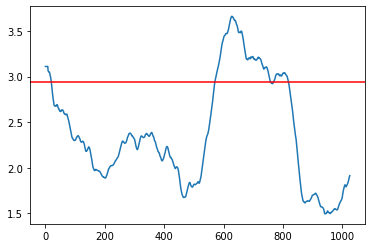

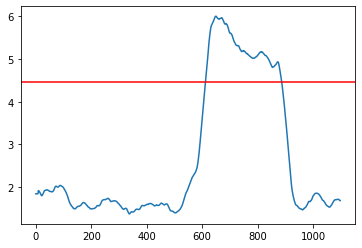

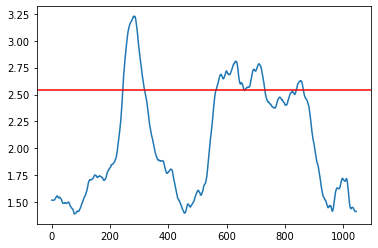

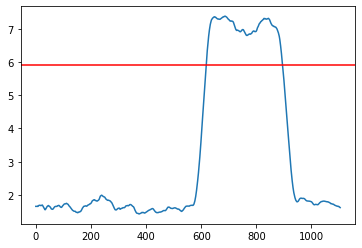

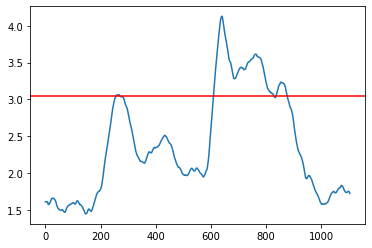

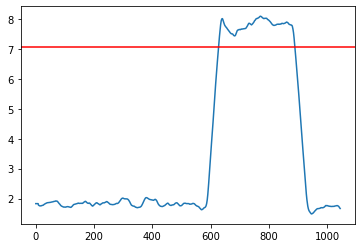

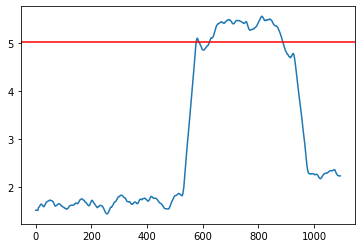

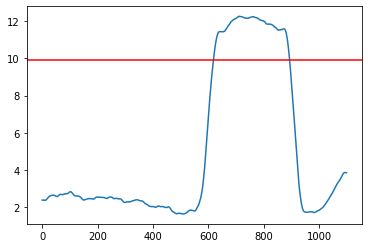

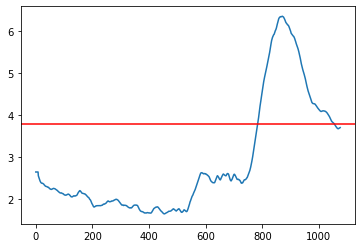

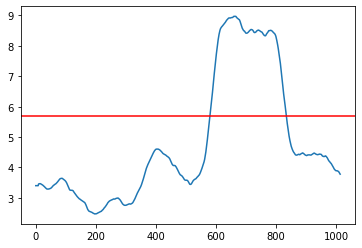

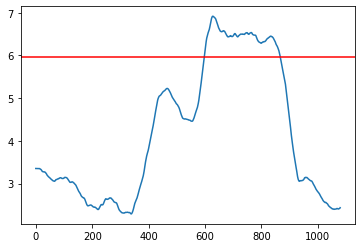

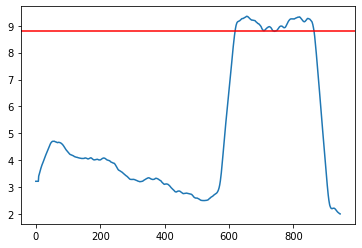

CPU times: total: 32min 31s
Wall time: 30min 42s


In [8]:
%%time

df_by_names = load_df_by_names("./data/", ["valve1", "valve2"])
# df_by_names = load_df_by_names("./data/", ["valve2"])
y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = predictor.predict(df_by_names)

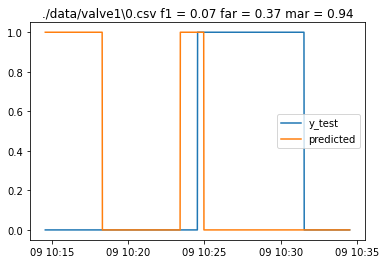

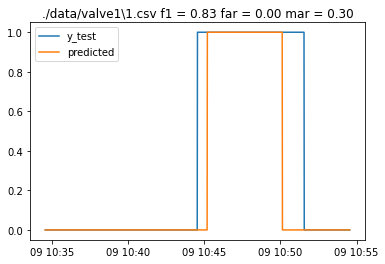

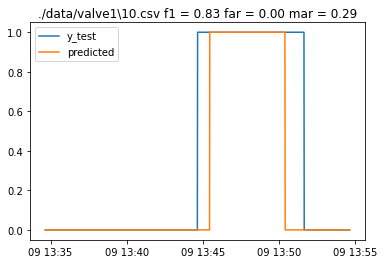

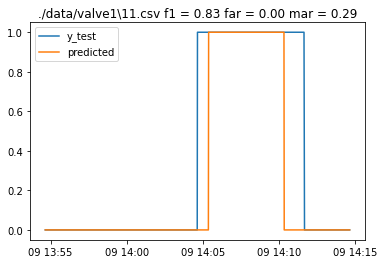

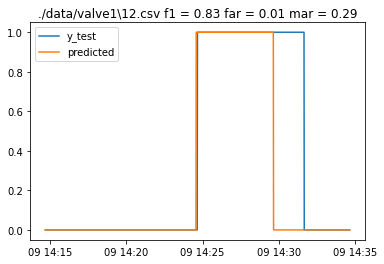

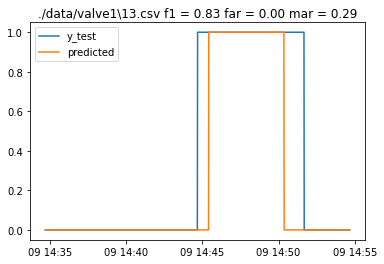

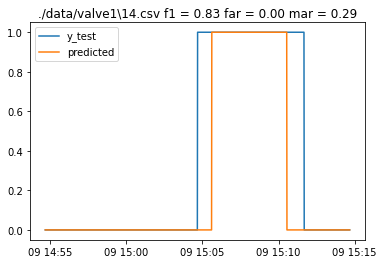

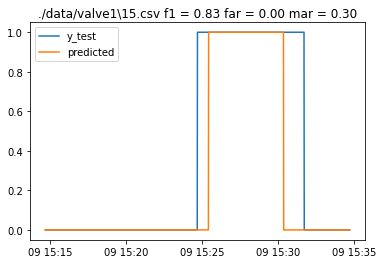

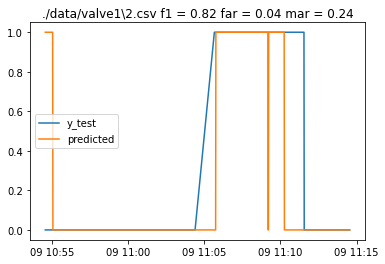

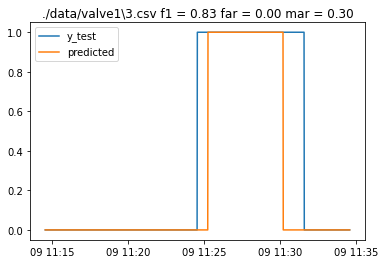

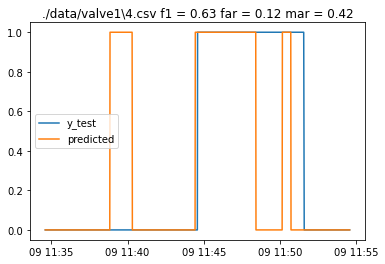

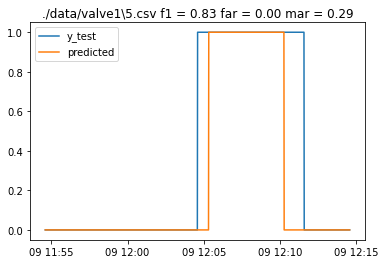

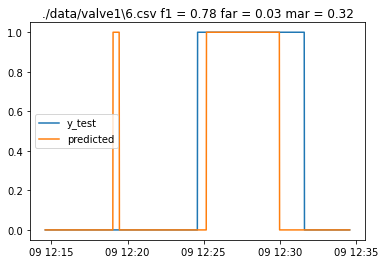

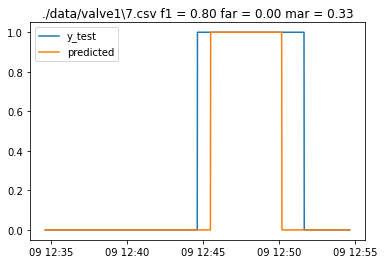

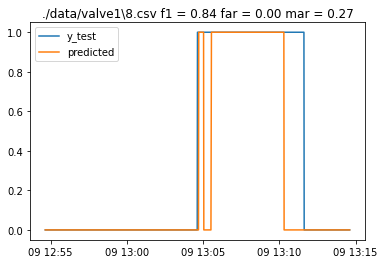

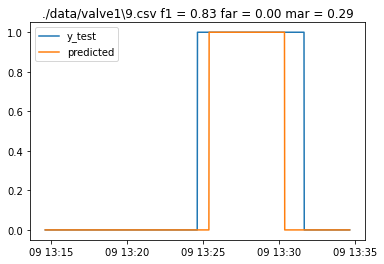

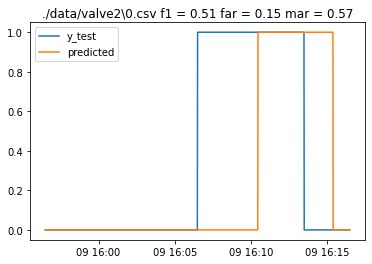

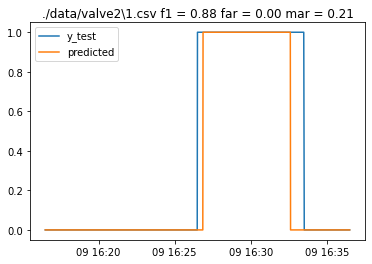

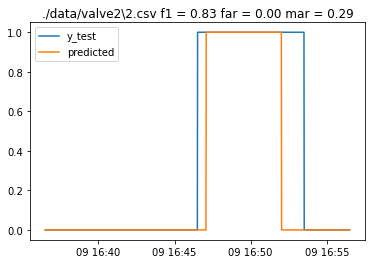

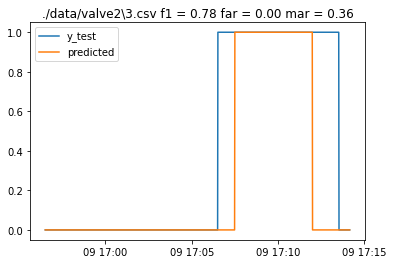

In [9]:
metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    # all_test.append(y_test)
    # all_prediction.append(prediction)
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [10]:
from utils.data import show_score_table

show_score_table(metrics)

metric | valve1\0.csv | valve1\1.csv | valve1\10.csv | valve1\11.csv | valve1\12.csv | valve1\13.csv | valve1\14.csv | valve1\15.csv | valve1\2.csv | valve1\3.csv | valve1\4.csv | valve1\5.csv | valve1\6.csv | valve1\7.csv | valve1\8.csv | valve1\9.csv | valve2\0.csv | valve2\1.csv | valve2\2.csv | valve2\3.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.07 | 0.83 | 0.83 | 0.83 | 0.83 | 0.83 | 0.83 | 0.83 | 0.82 | 0.83 | 0.63 | 0.83 | 0.78 | 0.8 | 0.84 | 0.83 | 0.51 | 0.88 | 0.83 | 0.78
FAR |0.37 | 0.0 | 0.0 | 0.0 | 0.01 | 0.0 | 0.0 | 0.0 | 0.04 | 0.0 | 0.12 | 0.0 | 0.03 | 0.0 | 0.0 | 0.0 | 0.15 | 0.0 | 0.0 | 0.0
MAR |0.94 | 0.3 | 0.29 | 0.29 | 0.29 | 0.29 | 0.29 | 0.3 | 0.24 | 0.3 | 0.42 | 0.29 | 0.32 | 0.33 | 0.27 | 0.29 | 0.57 | 0.21 | 0.29 | 0.36

In [11]:
show_score_table(grouped_metrics)

metric | valve1 | valve2
--- | --- | ---
F1 |0.76 | 0.75
FAR |0.04 | 0.04
MAR |0.34 | 0.36